# Прогноз невыполнения кредитных обязательств

## 1. Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

In [2]:
RANDOM_STATE = 64
DATA_PATH = Path('./data')

plt.style.use('fivethirtyeight') 
plt.rc('font', size=8)

## 2. Загрузка данных

**Описание датасета**

* Home Ownership - домовладение
* Annual Income - годовой доход
* Years in current job - количество лет на текущем месте работы
* Tax Liens - налоговые обременения
* Number of Open Accounts - количество открытых счетов
* Years of Credit History - количество лет кредитной истории
* Maximum Open Credit - наибольший открытый кредит
* Number of Credit Problems - количество проблем с кредитом
* Months since last delinquent - количество месяцев с последней просрочки платежа
* Bankruptcies - банкротства
* Purpose - цель кредита
* Term - срок кредита
* Current Loan Amount - текущая сумма кредита
* Current Credit Balance - текущий кредитный баланс
* Monthly Debt - ежемесячный долг
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [3]:
data = pd.read_csv(DATA_PATH / 'train.csv')
data.sample(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
538,Rent,1213036.0,10+ years,0.0,11.0,15.8,305448.0,2.0,NaN,2.0,debt consolidation,Short Term,44594.0,13186.0,15769.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
4530,Rent,772844.0,< 1 year,0.0,4.0,15.1,212520.0,0.0,61.0,0.0,business loan,Long Term,134222.0,151962.0,4289.0,702.0,1
2140,Rent,NaN,3 years,0.0,13.0,8.7,621632.0,0.0,NaN,0.0,debt consolidation,Short Term,232980.0,178239.0,12217.0,NaN,0
131,Rent,753464.0,< 1 year,0.0,12.0,14.3,516692.0,0.0,NaN,0.0,debt consolidation,Short Term,133056.0,319504.0,10862.0,740.0,0


## 3. EDA и очистка данных

### 3.1. Анализ целевой переменной

0    5387
1    2113
Name: Credit Default, dtype: int64


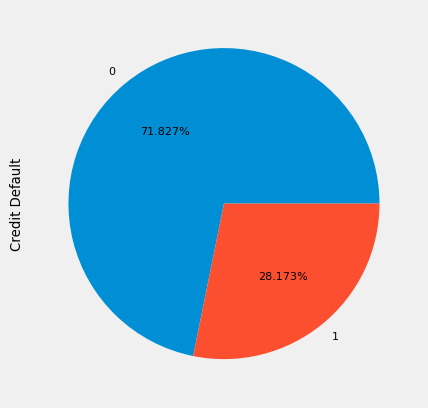

In [4]:
data['Credit Default'].value_counts().plot(kind='pie', autopct=lambda pct: f'{pct:.3f}%')
plt.show()

У целевой переменной наблюдается дисбаланс классов

### 3.2. Анализ признаков

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

В датасете есть пропуски по столбцам:
* Annual Income
* Years in current job
* Months since last delinquent
* Bankruptcies
* Credit Score

Помним, что отсутствие данных может тоже являтся информацией.

**Annual Income**
Предположим, что отсутсвие информации по доходу является отсутствем дохода.

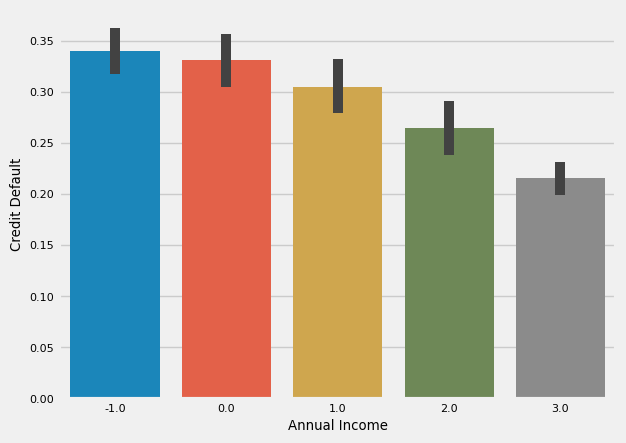

In [6]:
annualIncome = data['Annual Income'].copy()
groups = pd.qcut(annualIncome, q=[0, 0.2, 0.4, 0.6, 1], labels=False, duplicates='drop')
groups.loc[annualIncome.isna()] = -1
sns.barplot(x=groups, y=data['Credit Default'])
plt.show()

In [7]:
data[annualIncome.isna()]['Years in current job'].isna().value_counts()

False    1482
True       75
Name: Years in current job, dtype: int64

<Axes: >

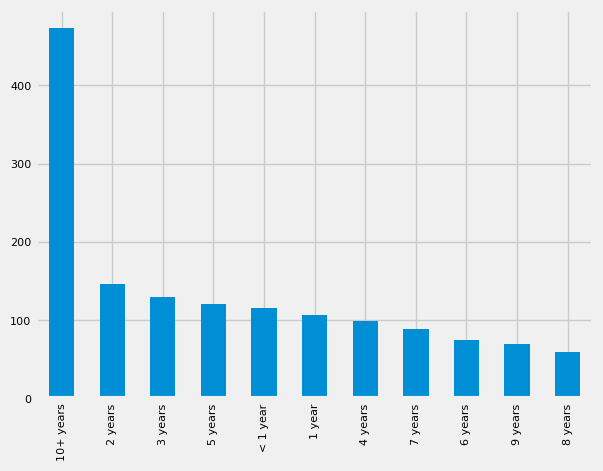

In [16]:
data[annualIncome.isna()]['Years in current job'].value_counts().plot(kind='bar')

Зависимость прослеживается, будем считать, что пропуски - это нулевой доход, хотя столбец `Years in current job` нам подсказывает, что это не так.

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


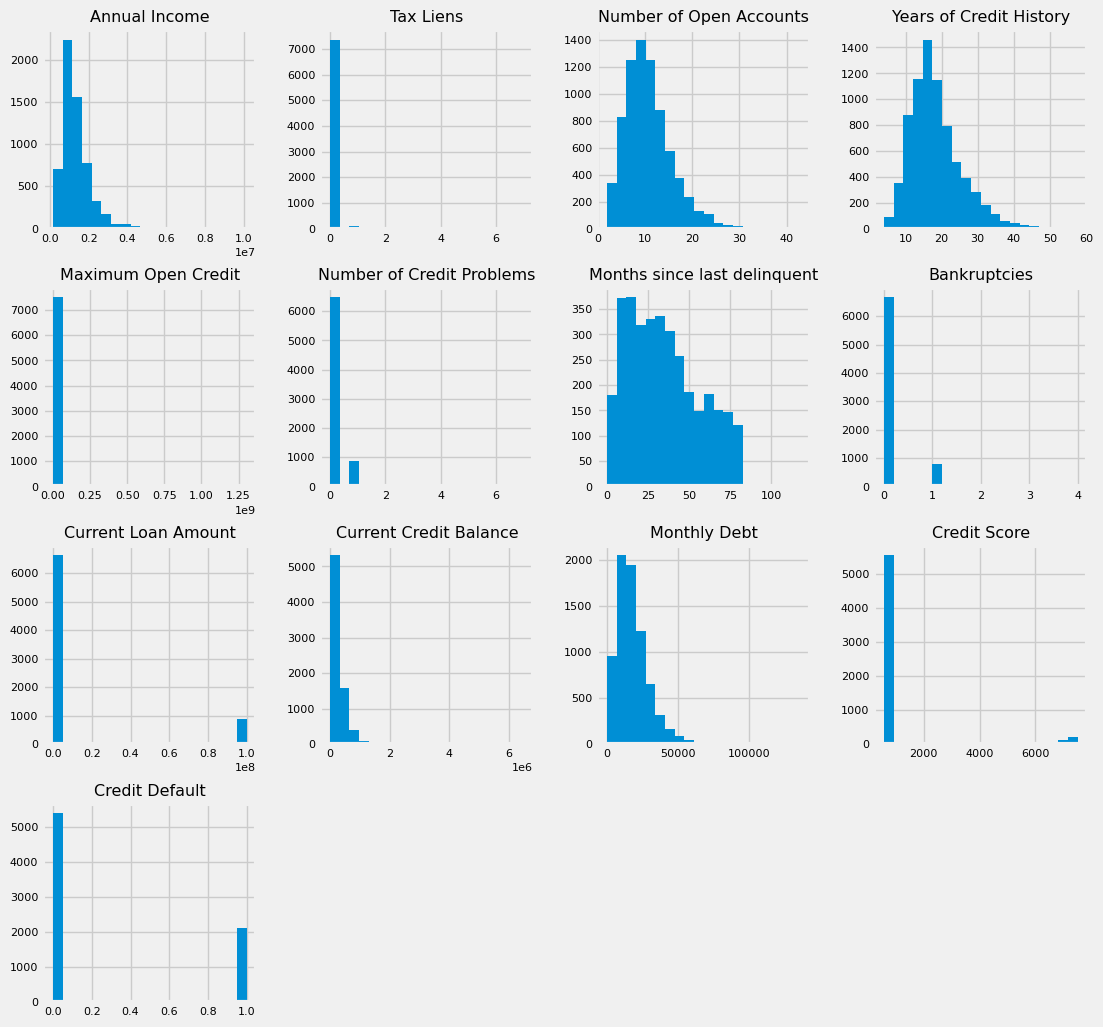

In [10]:
num_feat = list(data.select_dtypes(exclude='object').columns)
data[num_feat].hist(figsize=(12,12), bins=20)
plt.show()

In [11]:
for col in data.columns:
    val_count = len(data[col].unique())
    print(f'{col}: {val_count}')
    if val_count <= 20:
        print('\t', data[col].unique())
    
    print('')

Home Ownership: 4
	 ['Own Home' 'Home Mortgage' 'Rent' 'Have Mortgage']

Annual Income: 5479

Years in current job: 12
	 [nan '10+ years' '8 years' '6 years' '7 years' '5 years' '1 year'
 '< 1 year' '4 years' '3 years' '2 years' '9 years']

Tax Liens: 8
	 [0. 3. 1. 2. 4. 6. 5. 7.]

Number of Open Accounts: 39

Years of Credit History: 408

Maximum Open Credit: 6963

Number of Credit Problems: 8
	 [1. 0. 3. 2. 6. 4. 5. 7.]

Months since last delinquent: 90

Bankruptcies: 6
	 [ 1.  0.  3. nan  2.  4.]

Purpose: 15
	 ['debt consolidation' 'other' 'home improvements' 'take a trip'
 'buy a car' 'small business' 'business loan' 'wedding'
 'educational expenses' 'buy house' 'medical bills' 'moving'
 'major purchase' 'vacation' 'renewable energy']

Term: 2
	 ['Short Term' 'Long Term']

Current Loan Amount: 5386

Current Credit Balance: 6592

Monthly Debt: 6716

Credit Score: 269

Credit Default: 2
	 [0 1]



### 3.3. Анализ зависимости таргета от фичей

## 4: Очистка данных и Feature engineering

## 5. Разбиение на train / test

## 6. Построение модели

## 7. Оценка финальной модели